### 모드 붕괴
* 위와 같이 어떠한 값이 들어와도 같은 모양의 이미지를 생성하게 되는 것을 의미함
* 생성자가 판별자보다 앞서갔을 경우 가장 잘 만들었던 이미지를 계속해서 만들어 내는 것이라고 생각해볼 수 있음
* 이러한 문제를 해결하기 위해서는 판별자를 생성자보다 더 많이 훈련시킬수 있지만 효과는 없다
* 결국 훈련의 질이 중요하다

### 모드 붕괴를 해결하기 위한 방법들
1. loss_function 수정
2. 모델 아키텍쳐 수정
3. optimiser 변경
4. 생성자 입력 seed 증가(시작 node의 개수 증가)
5. 학습을 좀 더 길게

In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd

import numpy
import random
import matplotlib.pyplot as plt

### dataset 정의

In [3]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass


In [4]:

#데이터 로드

mnist_dataset = MnistDataset('/content/mount/MyDrive/동훈/딥러닝 스터디/GAN/DATA/mnist_train.csv')

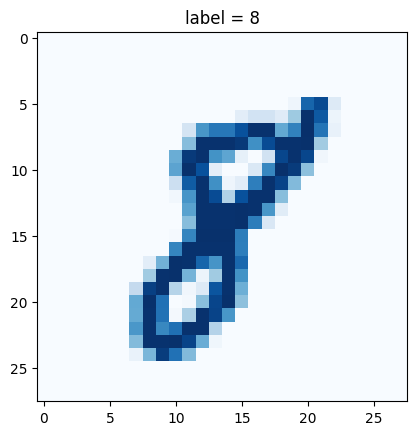

In [5]:
mnist_dataset.plot_image(17)

#### 데이터 생성 함수

In [6]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

### 판별자 네트워크

In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

    pass

#### 판별기 테스트

In [8]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    #실제 데이터
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    #생성된 데이터
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


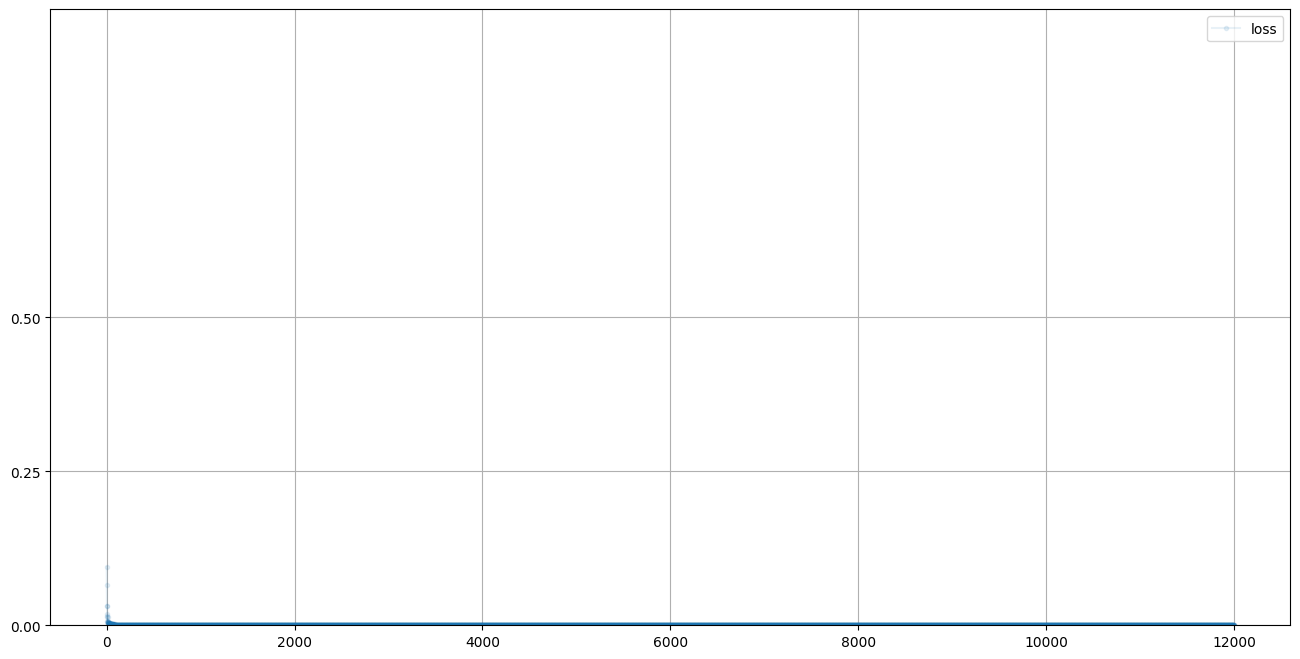

In [9]:
D.plot_progress()

In [10]:
#임의로 선택한 이미지와 랜덤값(생성)을 학습한 모델에 넣어보면
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print("학습 이미지 값 : ", D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print("랜덤으로 생성한 값 : ", D.forward(generate_random_image(784) ).item() )
  pass

학습 이미지 값 :  1.0
학습 이미지 값 :  1.0
학습 이미지 값 :  1.0
학습 이미지 값 :  1.0
랜덤으로 생성한 값 :  1.0411136362742379e-11
랜덤으로 생성한 값 :  9.8088282288189e-12
랜덤으로 생성한 값 :  9.196246195108948e-12
랜덤으로 생성한 값 :  9.05890553543065e-12


### 생성자 네트워크

In [11]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200,784),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

        self.counter = 0
        self.progress =[]

        pass

    def forward(self,inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        #이미지 생성
        g_output = self.forward(inputs)

        #생성한 값을 판별
        d_output = D.forward(g_output)

        #판별한 값과 loss계산
        loss = D.loss_function(d_output, targets)

        #로깅
        self.counter +=1;
        if self.counter%10==0:
            self.progress.append(loss.item())

            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass



#### 생성자 테스트

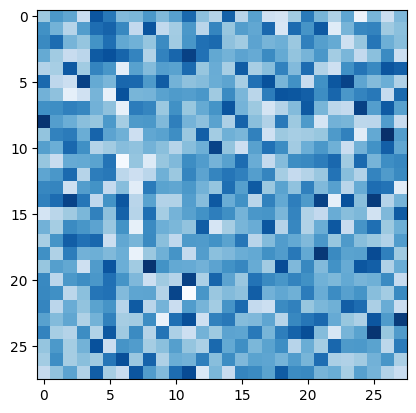

In [12]:
G = Generator()

output = G.forward(generate_random_seed(100))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation = 'none', cmap='Blues')

### GAN 학습

In [13]:
%%time

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, target_tensor in mnist_dataset:

    #정상 이미지 -> 1로 판별
    D.train(image_data_tensor, torch.FloatTensor([1.0]))

    #가짜 이미지 -> 0으로 판별
    D.train(G.forward(generate_random_seed(100)), torch.FloatTensor([0.0]))

    #정상에 가깝게 생성
    G.train(D,generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 16min 44s, sys: 1.65 s, total: 16min 46s
Wall time: 16min 51s


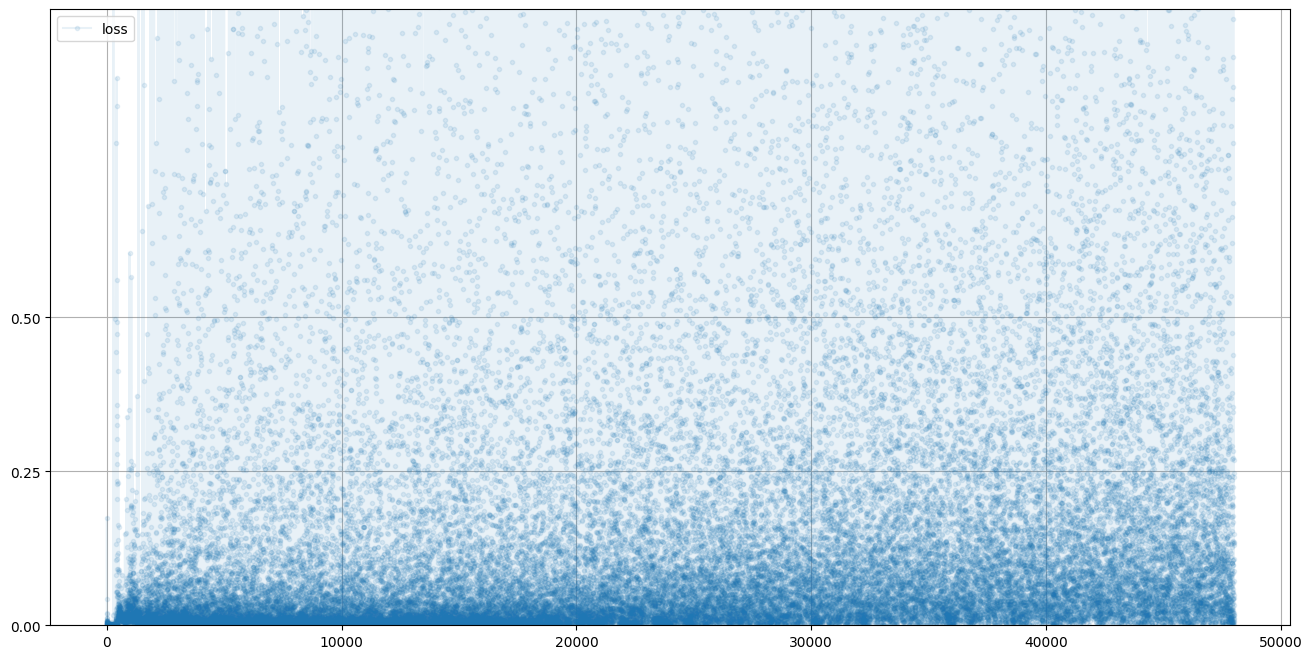

In [14]:

# plot discriminator error

D.plot_progress()

그래프 해석
* 손실이 빠르게 0으로 수렴하면서 유지되는 것 같지만 점프가 계속 발생
* 판별자와 생성자 사이의 균형이 맞춰지지 않았다는 의미

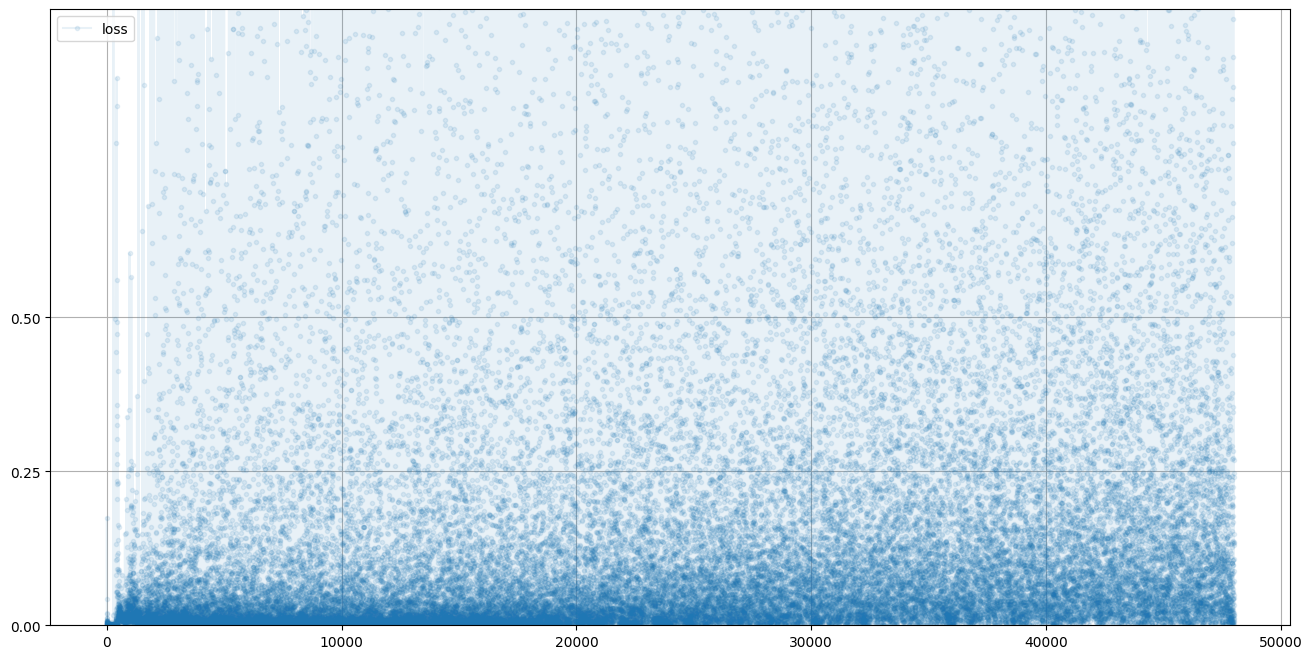

In [15]:

# plot discriminator error

D.plot_progress()

그래프 해석
* 손실이 처음에는 튀어오르는 것은 생성자가 판별자의 성능에 뒤쳐지는것
* 손실이 떨어진 이후에는 3 근처에 머무는데 BCEloss의 계산 방식 때문
* 손실값들이 넓은 범위에 걸쳐 존재하는 것보다는 어느정도 고정된 값을 중심으로 약간의 변화가 있는것이 바람직한 것

### 이미지 생성

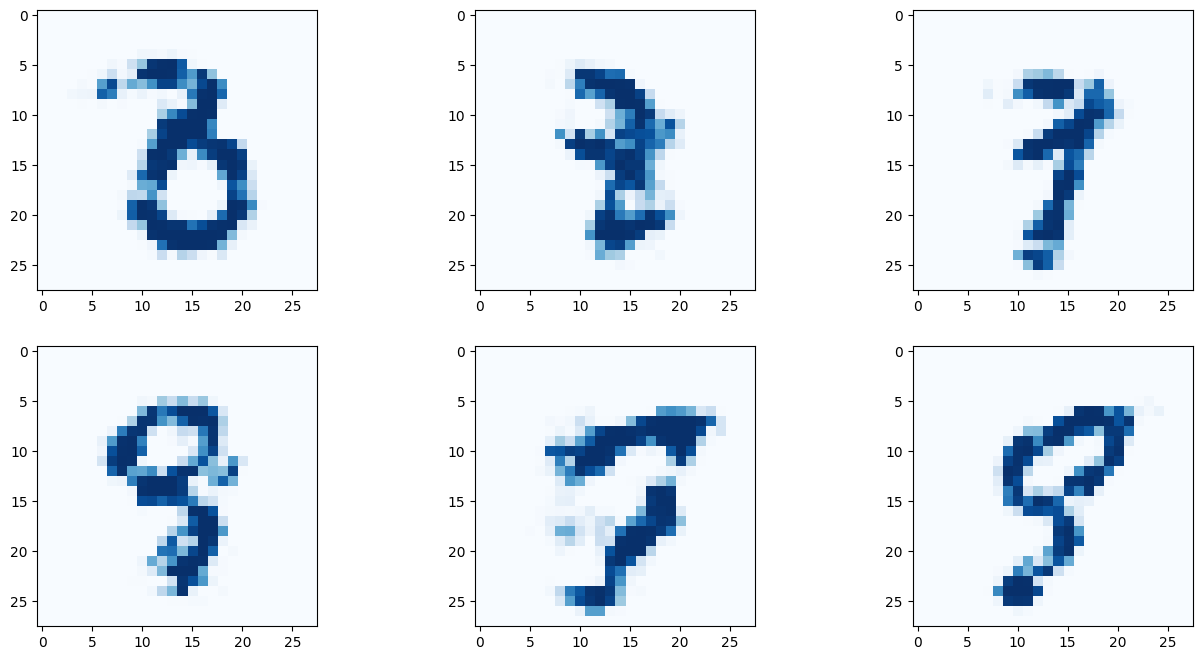

In [16]:

# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

### SEED의 의미
생성자의 초기 노드인 seed는 어떠한 것을 의미할까?
- seed1이 숫자 5를 seed2가 숫자 3을 생성한다고 가정할때, 두 시드를 더한 값은 두 이미지를 합친 형태이지만 뺸 경우는 어떠한 직관적인 패턴을 따르지 않는다.

- 두 시드가 유사한 숫자형태인 9를 생성한다고 가정할때 두 시드를 더한 값으로 생성했을때 9를 생성하고 뺀 값을 생성하면 7을 생성할 수 도 있다.


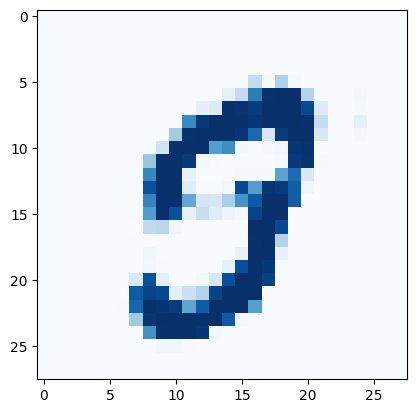

In [17]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

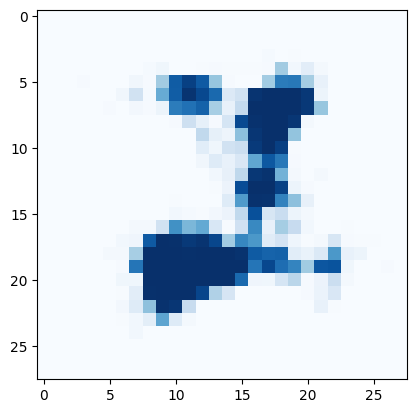

In [18]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

seed1과 seed2를 12단계로 나누어서 중간 seed값마다 이미지를 생성
* 값의 변화에 따라 이미지가 어떻게 변화하는지 확인해볼 수 있음

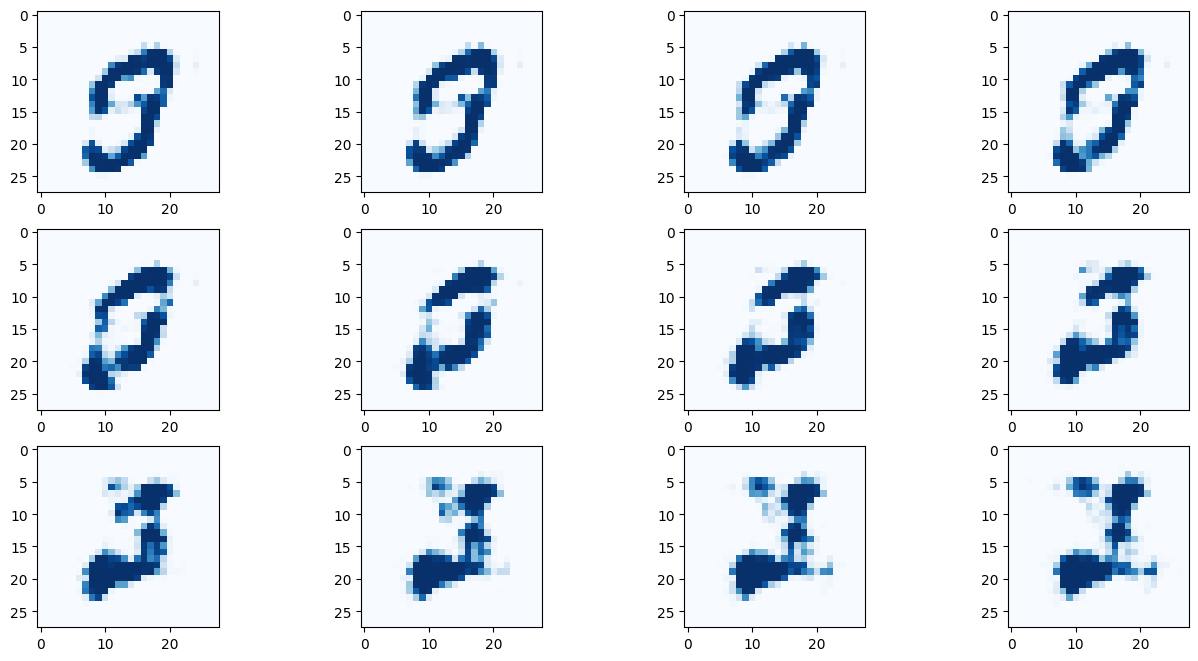

In [19]:
count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

시드끼리 더하면 어떻게 될까?

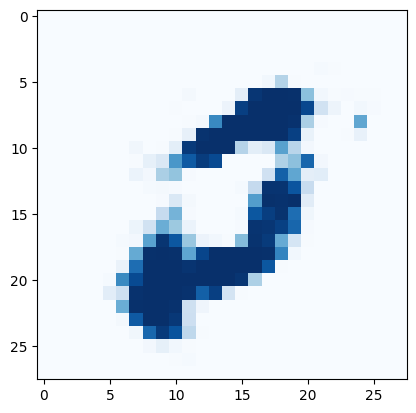

In [20]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

시드끼리 빼면?

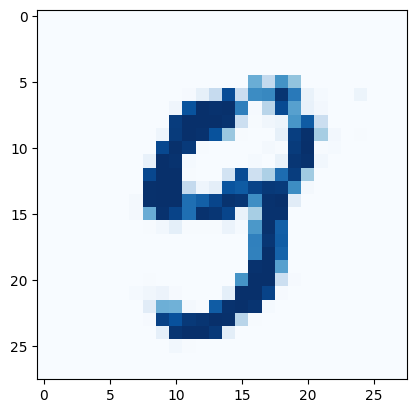

In [21]:
seed3 = seed1 - seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')